In [39]:
%load_ext autoreload
%autoreload 2
import transformers
import torch
import os.path
import math
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from mcllm.model.llm import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.utils.data as data
from mcllm.data.synthetic import LowRankDataset
from pprint import pprint

import lightning.pytorch as pl
import mcllm.config
import mcllm.model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# create a dataloader
m = 10
n = 10
rank = 3
frac_nan_mask = 0.1
seed = 13
use_rowcol_attn = 1
n_registers = 2
dataset = LowRankDataset(m, n, rank, frac_nan_mask, seed=seed,
                         n_registers=n_registers, use_rowcol_attn=use_rowcol_attn)

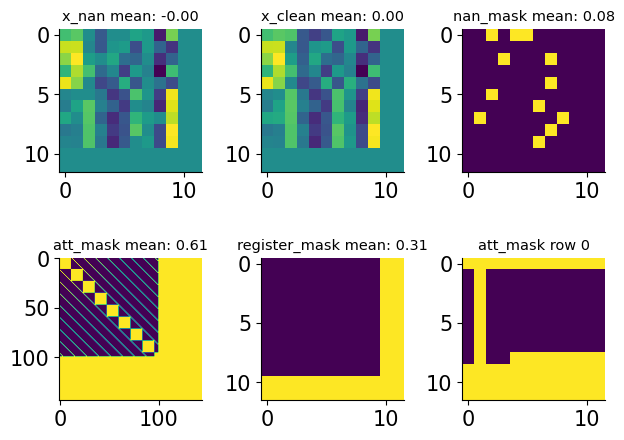

In [54]:
# visualize each of these matrices as a heatmap with title as the variable name
x_nan_t, x_clean_t, nan_mask_t, att_mask_t, register_mask_t = dataset[0]
mat_dict = {
    'x_nan': x_nan_t,
    'x_clean': x_clean_t,
    'nan_mask': nan_mask_t,
    'att_mask': att_mask_t,
    'register_mask': register_mask_t
}
for i, (k, v) in enumerate(mat_dict.items()):
    plt.subplot(2, 3, i+1)
    if not k == 'att_mask':
        plt.imshow(v.reshape(m + n_registers, n + n_registers))
    else:
        plt.imshow(v)
    plt.title(f'{k} mean: {v.mean().item():.2f}', fontsize='x-small')

# att_mask 0
plt.subplot(2, 3, i+1 + 1)
plt.title('att_mask row 0', fontsize='x-small')
plt.imshow(att_mask_t[1].reshape(m + n_registers, n + n_registers))

# Make prediction with model

In [45]:
ckpt = os.path.join(
    mcllm.config.path_to_repo,
    'results', 'rowcol=1__reg=2__small', 'epoch=143-step=1152.ckpt')
checkpoint = os.path.join(ckpt, 'checkpoint', 'mp_rank_00_model_states.pt')
device = 'cuda'
d = torch.load(checkpoint)
module = mcllm.model.llm.TabLLM(**d['hyper_parameters'])
module.load_state_dict(d['module'])
module = module.to('cuda').eval()
pprint(d['hyper_parameters'])

{'dropout': 0,
 'learning_rate': 0.001,
 'n_columns_list': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 'n_embed': 16,
 'n_heads': 8,
 'n_layers': 6,
 'n_registers': 2,
 'n_rows_list': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 'use_pos_embeddings': False}


In [46]:
def unsqueeze(tensor_tuple):
    return tuple(t.unsqueeze(0).to(device) for t in tensor_tuple)


# add batch dimension
x_nan, x_clean, nan_mask, att_mask, register_mask = unsqueeze(
    (x_nan_t, x_clean_t, nan_mask_t, att_mask_t, register_mask_t))

In [47]:
output = module(x_nan, nan_mask, att_mask,
                register_mask, n_rows=m, n_columns=n)
x_pred = output.detach().cpu().numpy().squeeze().reshape(
    (m + n_registers, n + n_registers))

shapes torch.Size([1, 144, 15]) torch.Size([1, 144])


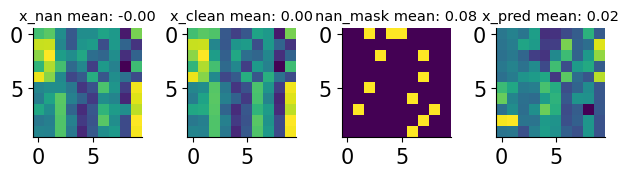

In [49]:
mat_dict = {
    'x_nan': x_nan_t,
    'x_clean': x_clean_t,
    'nan_mask': nan_mask_t,
    'x_pred': x_pred,
}
for i, (k, v) in enumerate(mat_dict.items()):
    plt.subplot(1, 4, i+1)
    plt.imshow(v.reshape(m + n_registers, n + n_registers)[:m, :n])
    plt.title(f'{k} mean: {v.mean().item():.2f}', fontsize='x-small')

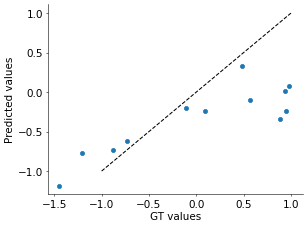

In [50]:
plt.figure(dpi=50)
plt.plot(x_clean_t[nan_mask_t.bool()], out.flatten()[nan_mask_t.bool()], 'o')
plt.plot([-1, 1], [-1, 1], 'k--')
plt.xlabel('GT values')
plt.ylabel('Predicted values')
plt.show()

# Decompose forward pass

In [51]:
# concatenate everything into initial input
x = module.embedding(x_nan, nan_mask, register_mask,
                     n_rows=m, n_columns=n)
print('emb', x.shape)

# apply each encoding layer
for layer in module.tab_layers:
    x = layer(x, att_mask)
print('enc', x.shape)

# project embedding size to scalar matrix
mat = module.unembedding(x).squeeze(-1)
assert np.allclose(mat.detach().cpu().numpy(), output.detach().cpu(
).numpy()), 'this decomposition should produce the same output'

shapes torch.Size([1, 144, 15]) torch.Size([1, 144])
emb torch.Size([1, 144, 16])
enc torch.Size([1, 144, 16])


In [52]:
# registers at each layer are always in the same positions indicated by reg_mask
# x is (batch_size, seq_len, emb_size) so let's reshape it to (m + n_registers, n + n_registers, emb_size)
# reg_vals are located at the right and bottom of this matrix
x = x.squeeze().reshape(m + n_registers, n + n_registers, -1)
x = x.detach().cpu().numpy()

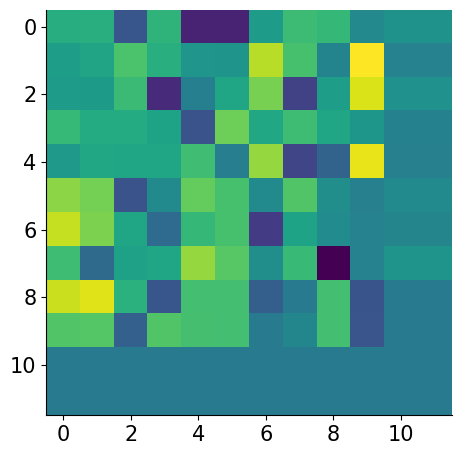

In [53]:
plt.imshow(x.mean(axis=-1))